# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print(state_size)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
24


### 3. Defining the Agent Class

In the next block I've defined the Agent class which actually performs as a multi agent (with two agents). The multiagent is composed of two Actors and one common Critic.

I'm also defining auxiliary classes for the OUNoise and the ReplayBuffer.

In [5]:
#Agent class definition
import numpy as np
import random
import copy
from collections import namedtuple, deque
from networkforall import Network


import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 1024       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
TRAIN_EVERY = 1         # 
NUM_AGENTS = 2          # How many agents are there in the environment
REPEAT_LEARN = 1        # How many times to call the learn method at each episode
UPDATE_EVERY = 4        # How many iterations to wait before updating target networks

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        in_actor = state_size
        out_actor = action_size
        in_critic = in_actor * 2
        hidden_in_actor = 256
        hidden_out_actor = 128
        hidden_in_critic = hidden_in_actor
        hidden_out_critic = hidden_out_actor
        
        # Actor Network (w/ Target Network)
        self.agents = []
        for _ in range(NUM_AGENTS) :
            agent = {}
            agent["actor_local"] = \
                  Network(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor=True, seed=random_seed).to(device)
            agent["actor_target"] = \
                  Network(in_actor, hidden_in_actor, hidden_out_actor, out_actor, actor=True, seed=random_seed).to(device)
            agent["optimizer"] =  optim.Adam(agent["actor_local"].parameters(), lr=LR_ACTOR) #, weight_decay=WEIGHT_DECAY) 
            self.agents.append(agent)

        # Critic Network (w/ Target Network)
        self.critic_local = Network(in_critic, hidden_in_critic, hidden_out_critic, 1, out_actor, actor=False, seed=random_seed).to(device)
        self.critic_target = Network(in_critic, hidden_in_critic, hidden_out_critic, 1, out_actor, actor=False, seed=random_seed).to(device)

        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        #Copy the weights from local to target networks
        self.soft_update(self.critic_local, self.critic_target, 1)
        for i in range(NUM_AGENTS):
            self.soft_update(self.agents[i]["actor_local"], self.agents[i]["actor_target"], 1)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, step, agent_i):
        """Save experience in replay memory, and use random sample from buffer to learn."""

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and (step % TRAIN_EVERY) == 0 :
            for _ in range(REPEAT_LEARN) :
                experiences = self.memory.sample()
                self.learn(experiences, agent_i, GAMMA, step)

    def act(self, state, agent_i, noise, add_noise=True):
        """Returns actions for given state as per current policy."""

        #Convert the state array to tensor
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        actor_l = self.agents[agent_i]["actor_local"]
        actor_l.eval()

        with torch.no_grad():
            action = actor_l(state).cpu().data.numpy()

        #Perform a training step
        actor_l.train()
        #Add noise to the obtained action
        if add_noise:
            action += self.noise.sample() * noise

        #Ensure the output is in the valid action's range [-1, 1]
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, agent_i, gamma, step):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
                
        states, actions, rewards, next_states, full_state, all_actions, full_next_state, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        # Get action from actor's network, given the NEXT state   
        actor_l = self.agents[agent_i]["actor_local"]
        actor_t = self.agents[agent_i]["actor_target"]
        other_act_l = self.agents[1 - agent_i]["actor_local"]
        other_act_t = self.agents[1 - agent_i]["actor_target"]
 
        full_nx_st_vw = full_next_state.view(BATCH_SIZE, 2, -1)
        actions_next = [actor_t(full_nx_st_vw[:, agent_i, :]), \
                        other_act_t(full_nx_st_vw[:, 1 - agent_i, :]) ]
        # Use the obtained action as input to the critic's network, along with the NEXT state
        actions_next = torch.cat(actions_next, dim=1)
        with torch.no_grad():
            Q_targets_next = self.critic_target(full_next_state, actions_next).detach()

        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        #Get the expected value from the critic's local network
        Q_expected = self.critic_local(full_state, all_actions)

        # Compute critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()

        #Gradient clipping
        ##torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        # Get the "best" action using the actor's local network, given current state
        full_st_vw = full_state.view(BATCH_SIZE, 2, -1)
        actions_pred = [actor_l(full_st_vw[:, agent_i, :]), \
                        other_act_l(full_st_vw[:, 1 - agent_i, :]) ]

        # Compute the loss by getting the expected value (V) from the critic's local network,
        # given the current state and the obtained action. 
        actions_pred = torch.cat(actions_pred, dim=1)
        actor_loss = -self.critic_local(full_state, actions_pred).mean()

        # Minimize the loss
        self.agents[agent_i]["optimizer"].zero_grad()
        actor_loss.backward()

        # Gradient clipping
        ##torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.agents[agent_i]["optimizer"].step()
        # ----------------------- update target networks ----------------------- #
        if step % UPDATE_EVERY == 0:
            self.soft_update(self.critic_local, self.critic_target, TAU)
            self.soft_update(actor_l, actor_t, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, shape, seed, mu=0., theta=0.15, sigma=0.08):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(shape)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * (np.random.rand(*x.shape)-0.5)
        self.state = x + dx

        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", \
                                     field_names=["state", "action", "reward", "next_state", "full_state", \
                                                  "all_actions", "full_next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, full_state, all_actions, full_next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, full_state, all_actions, full_next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        full_states = torch.from_numpy(np.vstack([e.full_state for e in experiences if e is not None])).float().to(device)
        all_actions = torch.from_numpy(np.vstack([e.all_actions for e in experiences if e is not None])).float().to(device)
        full_next_states = torch.from_numpy(np.vstack([e.full_next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, full_states, all_actions, full_next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
scores = []    # A list to store the scores of all episodes
avg_scores = []
seed = random.seed(2)
# The DDPG implementation
def ddpg(n_episodes=5000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)                  # A queue to keep only the last 100 episodes' scores

    noise = 2
    noise_reduction = 0.9999
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    

        #states is an array of the states for all the 20 agents.
        states = env_info.vector_observations                 # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        
        agent.reset()                                         # Reset the agent to start the episode
        for t in range(max_t):                                # A loop for the iterations
            if i_episode < 50 :                               # Random actions at the beginning 
                actions = np.random.randint(0, 20000, (num_agents, action_size)) / 10000 - 1
                actions = np.clip(actions, -1, 1)             # all actions between -1 and 1
            else :
                # Get an action from the Actor's network, given the current state
                actions = [agent.act(states[0], 0, noise)[0], agent.act(states[1], 1, noise)[0]] 
            env_info = env.step(actions)[brain_name]          # send all actions to the environment
            next_states = env_info.vector_observations        # get next state (for each agent)
            rewards = env_info.rewards                        # get reward (for each agent)
            dones = env_info.local_done                       # see if episode finished
            score += env_info.rewards                         # update the score (for each agent)

            # Save interaction in memory buffer (s,a,r,ns,full_st, all_act, full_ns, done).
            full_states = [st for el in states for st in el]
            full_next_states = [st for el in next_states for st in el]
            all_actions = [st for el in actions for st in el]
            
            # This function receives states, actions, etc. of one agent at a time
            for a_i in range(2) :
                agent.memory.add(states[a_i], actions[a_i], rewards[a_i], next_states[a_i], full_states, \
                           all_actions, full_next_states, dones[a_i])
            # Perform an agent step
            for a_i in range(2) :
                agent.step(i_episode, a_i)

            states = next_states                              # Roll over states to next time step
            noise *= noise_reduction
            if np.any(dones):                                 # exit loop if episode finished
                break
                
        score = max(score)                                    # Get the mean score of the episode (over all agents)
        scores_deque.append(score)                            # Store the score in the queue
        scores.append(score)                                  # Store the score in the list (for plotting)
        
        # Print out the mean score per episode
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")

        mean_sc = np.mean(scores_deque)                       # Compute the mean score over the last 100 episodes
        avg_scores.append(mean_sc)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_sc))
            
        if len(scores_deque) == 100 and mean_sc >= 0.5 :
            print('\rEnvironment solved in {} episodes, mean score: {:.2f}'.format(i_episode, mean_sc))
            torch.save(agent.agents[0]["actor_local"].state_dict(), 'checkpoint_actor1.pth')
            torch.save(agent.agents[1]["actor_local"].state_dict(), 'checkpoint_actor2.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores

 
print("start")
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)
scores = ddpg()
print("end")

start
Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.02
Episode 700	Average Score: 0.01
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.00
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.01
Episode 1200	Average Score: 0.04
Episode 1300	Average Score: 0.04
Episode 1400	Average Score: 0.02
Episode 1500	Average Score: 0.06
Episode 1600	Average Score: 0.06
Episode 1700	Average Score: 0.08
Episode 1800	Average Score: 0.09
Episode 1900	Average Score: 0.10
Episode 2000	Average Score: 0.08
Episode 2100	Average Score: 0.10
Episode 2200	Average Score: 0.10
Episode 2300	Average Score: 0.08
Episode 2400	Average Score: 0.08
Episode 2500	Average Score: 0.10
Episode 2600	Average Score: 0.11
Episode 2700	Average Score: 0.11
Episode 2800	Average Score: 0.13
Episode 2900	Average Score: 0.15
Episode 3000	Average Score: 0.20
Episode 3100	

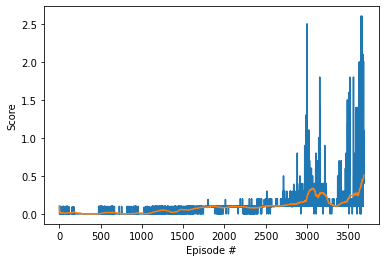

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
